In [1]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# TOKEN = user_secrets.get_secret("GITHUB_TOKEN")
#
# !git clone https://{TOKEN}@github.com/nicoloalbergoni/DeeplabV3Plus-TF2.git
# %load_ext tensorboard
# %cd ./DeeplabV3Plus-TF2

In [2]:
#!python download_and_prepare_voc.py --remove_cmap --download_berkley

In [3]:
import os
import random
import numpy as np
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from model import DeeplabV3Plus
import tensorflow_addons as tfa
from matplotlib import pyplot as plt
from superresolution import Superresolution
from utils import load_image, get_prediction, create_mask, plot_prediction
from superres_utils import get_img_paths, filter_by_class, min_max_normalization, plot_image, plot_histogram

In [4]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PASCAL_ROOT = os.path.join(DATA_DIR, "VOCdevkit", "VOC2012")
IMGS_PATH = os.path.join(PASCAL_ROOT, "JPEGImages")

SUPERRES_ROOT = os.path.join(DATA_DIR, "superres_root")
PRECOMPUTED_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "precomputed_features")
STANDARD_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "standard_output")
SUPERRES_OUTPUT_DIR = os.path.join(SUPERRES_ROOT, "superres_output")

# SEED = np.random.randint(0, 1000)
SEED = 1234
IMG_SIZE = (512, 512)
BATCH_SIZE = 2
BUFFER_SIZE = 1000
EPOCHS = 30
CLASSES = 21
RESHAPE_MASKS = True
NUM_AUG = 50
CLASS_ID = 8
NUM_SAMPLES = 300

In [5]:
image_list_path = os.path.join(DATA_DIR, "augmented_file_lists", "valaug.txt")
image_paths = get_img_paths(image_list_path, IMGS_PATH)

if NUM_SAMPLES is not None:
    image_paths = image_paths[:NUM_SAMPLES]

images_dict = filter_by_class(image_paths, class_id=CLASS_ID)

print(f"Valid images: {len(images_dict)} (Initial:  {len(image_paths)})")

valid_filenames = list(images_dict.keys())

model_no_upsample = DeeplabV3Plus(
    input_shape=(512, 512, 3),
    classes=21,
    OS=16,
    last_activation=None,
    load_weights=True,
    backbone="mobilenet",
    alpha=1.).build_model(final_upsample=False)

model_standard = DeeplabV3Plus(
    input_shape=(512, 512, 3),
    classes=21,
    OS=16,
    last_activation=None,
    load_weights=True,
    backbone="mobilenet",
    alpha=1.).build_model(final_upsample=True)

Valid images: 26 (Initial:  300)


# Compute standard output for comparison

In [6]:
def compute_standard_output(image_dict, model, dest_folder, filter_class_id=None):
    standard_masks = {}
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for key in tqdm(image_dict):
        standard_mask = get_prediction(model, image_dict[key])
        if filter_class_id is not None:
            standard_mask = tf.where(standard_mask == filter_class_id, standard_mask, 0) # Set to 0 all predictions different from the given class
        tf.keras.utils.save_img(f"{dest_folder}/{key}.png", standard_mask, scale=False)
        standard_masks[key] = standard_mask

    return standard_masks

In [7]:
standard_masks_dict = compute_standard_output(images_dict, model_standard, dest_folder=STANDARD_OUTPUT_DIR, filter_class_id=CLASS_ID)

100%|██████████| 26/26 [00:19<00:00,  1.36it/s]


# Precompute Augmented Output Features

In [8]:
def augment_image(image, num_aug, angle_max, shift_max):

    batched_images = tf.tile(tf.expand_dims(image, axis=0), [num_aug, 1, 1, 1])  # Size [num_aug, 512, 512, 3]
    angles = np.random.uniform(-angle_max, angle_max, num_aug)
    shifts = np.random.uniform(-shift_max, shift_max, (num_aug, 2))
    # First sample is not augmented
    angles[0] = 0
    shifts[0] = np.array([0, 0])
    angles = angles.astype("float32")
    shifts = shifts.astype("float32")

    rotated_images = tfa.image.rotate(batched_images, angles, interpolation="bilinear")
    translated_images = tfa.image.translate(rotated_images, shifts, interpolation="bilinear")

    return translated_images, angles, shifts

def compute_augmented_features(images_dict, model, dest_folder, filter_class_id=None, num_aug=100, angle_max=0.5, shift_max=30, save_output=False, relu_output=False):
    augmented_features = {}
    for filename in tqdm(images_dict):
        augmented_images, angles, shifts = augment_image(images_dict[filename], num_aug=num_aug, angle_max=angle_max, shift_max=shift_max)

        output_folder= os.path.join(dest_folder, filename)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        predictions = model.predict(augmented_images, batch_size=BATCH_SIZE)

        class_masks = []
        max_masks = []
        for i, prediction in enumerate(predictions):
            if filter_class_id is not None:
                class_mask = prediction[:, :, filter_class_id]
                no_class_prediction = np.delete(prediction, filter_class_id, axis=-1)
                max_mask = no_class_prediction.max(axis=-1)

                class_mask = class_mask[..., np.newaxis]
                max_mask = max_mask[..., np.newaxis]

                if relu_output:
                    class_mask = tf.nn.relu(class_mask)
                    max_mask = tf.nn.relu(max_mask)

            #mask = mask.numpy()
            #mask = min_max_normalization(mask, new_min=0.0, new_max=255.0)

            #mask_scaled = ((mask_npy - mask_npy.min()) * (1/(mask_npy.max() - mask_npy.min()) * 255)).astype('uint8')
            if save_output:
                tf.keras.utils.save_img(f"{output_folder}/{i}_class.png", class_mask, scale=True)
                tf.keras.utils.save_img(f"{output_folder}/{i}_max.png", max_mask, scale=True)

            np.save(os.path.join(output_folder, f"{filename}_angles"), angles)
            np.save(os.path.join(output_folder, f"{filename}_shifts"), shifts)

            class_masks.append(class_mask)
            max_masks.append(max_mask)

        augmented_features[filename] = { "class": class_masks, "max": max_masks }

    return augmented_features

In [9]:
angle_max = 0.5  # in radians
shift_max = 30

augmented_features_dict = compute_augmented_features(images_dict, model_no_upsample, dest_folder=PRECOMPUTED_OUTPUT_DIR, filter_class_id=CLASS_ID, num_aug=NUM_AUG, angle_max=angle_max, shift_max=shift_max, save_output=True, relu_output=False)

100%|██████████| 26/26 [01:41<00:00,  3.92s/it]


# Compute Super-Resolution Output

In [10]:
def compute_superresolution_output(augmented_features_dict, superresolution_obj, precomputed_root_dir, dest_folder, num_aug=100, save_output=False):

    superres_masks = {}
    losses = {}

    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    for filename in tqdm(augmented_features_dict):
        mask_dict = augmented_features_dict[filename]
        class_masks_array = mask_dict["class"]
        max_masks_array = mask_dict["max"]

        if not (len(class_masks_array) == num_aug and len(max_masks_array) == num_aug):
            print(f"Skipped folder named {filename} as it is not valid")
            continue

        # max_values = np.max(augmented_images, axis=(1, 2, 3), keepdims=True)
        # max_values[max_values == 0.] = 1.
        # augmented_images = augmented_images / max_values
        # augmented_images = tf.cast(augmented_images, tf.float32)

        class_masks = tf.stack(class_masks_array)
        max_masks = tf.stack(max_masks_array)

        class_masks = tf.map_fn(fn=lambda image: min_max_normalization(image.numpy(), new_min=0.0, new_max=1.0, global_min=tf.reduce_min(class_masks), global_max=tf.reduce_max(class_masks)), elems=class_masks)
        max_masks = tf.map_fn(fn=lambda image: min_max_normalization(image.numpy(), new_min=0.0, new_max=1.0, global_min=tf.reduce_min(max_masks), global_max=tf.reduce_max(max_masks)), elems=max_masks)

        # class_masks = tf.map_fn(fn=lambda image: min_max_normalization(image.numpy(), new_min=0.0, new_max=1.0), elems=class_masks)
        # max_masks = tf.map_fn(fn=lambda image: min_max_normalization(image.numpy(), new_min=0.0, new_max=1.0), elems=max_masks)

        precomputed_folder_path = os.path.join(precomputed_root_dir, filename)
        angles = np.load(os.path.join(precomputed_folder_path, f"{filename}_angles.npy"))
        shifts = np.load(os.path.join(precomputed_folder_path, f"{filename}_shifts.npy"))

        target_image_class, loss_class = superresolution_obj.compute_output(class_masks, angles, shifts)
        target_image_max, loss_max = superresolution_obj.compute_output(max_masks, angles, shifts)

        target_image_class = (target_image_class[0]).numpy()
        target_image_max = (target_image_max[0]).numpy()

        # target_image_class_scaled = min_max_normalization(target_image_class, new_min=0.0, new_max=255.0)
        # target_image_max_scaled = min_max_normalization(target_image_max, new_min=0.0, new_max=255.0)

        if save_output:
            tf.keras.utils.save_img(f"{dest_folder}/{filename}_class.png", target_image_class, scale=True)
            tf.keras.utils.save_img(f"{dest_folder}/{filename}_max.png", target_image_max, scale=True)

        superres_masks[filename] = { "class": target_image_class, "max": target_image_max }
        losses[filename] = (loss_class, loss_max)

    return superres_masks, losses

In [11]:
# super resolution parameters
learning_rate = 1e-3
lambda_eng = 0.0001 * NUM_AUG
lambda_tv = 0.002 * NUM_AUG
num_iter = 400

superresolution = Superresolution(
    lambda_tv=lambda_tv,
    lambda_eng=lambda_eng,
    num_iter=num_iter,
    num_aug=NUM_AUG,
    learning_rate=learning_rate,
    verbose=False
)

superres_masks_dict, losses = compute_superresolution_output(augmented_features_dict, superresolution, precomputed_root_dir=PRECOMPUTED_OUTPUT_DIR, dest_folder=SUPERRES_OUTPUT_DIR, num_aug=NUM_AUG, save_output=True)

  0%|          | 0/26 [00:00<?, ?it/s]

Final loss: 7230.23046875


  4%|▍         | 1/26 [00:43<18:05, 43.42s/it]

Final loss: 10051.8701171875
Final loss: 7216.2783203125


  8%|▊         | 2/26 [01:14<14:29, 36.22s/it]

Final loss: 21699.3125
Final loss: 7856.59765625


 12%|█▏        | 3/26 [01:47<13:13, 34.51s/it]

Final loss: 17445.90625
Final loss: 3849.840576171875


 15%|█▌        | 4/26 [02:18<12:10, 33.23s/it]

Final loss: 25048.47265625
Final loss: 7091.67138671875


 19%|█▉        | 5/26 [02:48<11:15, 32.18s/it]

Final loss: 16445.177734375
Final loss: 7509.70458984375


 23%|██▎       | 6/26 [03:22<10:53, 32.68s/it]

Final loss: 14264.6337890625
Final loss: 9575.73046875


 27%|██▋       | 7/26 [03:56<10:27, 33.04s/it]

Final loss: 18442.482421875
Final loss: 14033.2890625


 31%|███       | 8/26 [04:29<09:57, 33.18s/it]

Final loss: 14311.8017578125
Final loss: 5429.033203125


 35%|███▍      | 9/26 [05:03<09:25, 33.27s/it]

Final loss: 15709.25
Final loss: 6909.89697265625


 38%|███▊      | 10/26 [05:34<08:44, 32.77s/it]

Final loss: 11048.10546875
Final loss: 7195.00927734375


 42%|████▏     | 11/26 [06:07<08:12, 32.85s/it]

Final loss: 19277.525390625
Final loss: 4333.0859375


 46%|████▌     | 12/26 [06:40<07:40, 32.88s/it]

Final loss: 17190.529296875
Final loss: 9605.326171875


 50%|█████     | 13/26 [07:15<07:13, 33.38s/it]

Final loss: 11794.783203125
Final loss: 3417.8271484375


 54%|█████▍    | 14/26 [07:48<06:40, 33.38s/it]

Final loss: 17592.3203125
Final loss: 22920.66796875


 58%|█████▊    | 15/26 [08:23<06:11, 33.74s/it]

Final loss: 21017.6328125
Final loss: 23149.90234375


 62%|██████▏   | 16/26 [08:57<05:40, 34.00s/it]

Final loss: 15253.537109375
Final loss: 11708.00390625


 65%|██████▌   | 17/26 [09:31<05:05, 33.99s/it]

Final loss: 19058.50390625
Final loss: 6364.03515625


 69%|██████▉   | 18/26 [10:04<04:29, 33.74s/it]

Final loss: 12108.9404296875
Final loss: 7024.87939453125


 73%|███████▎  | 19/26 [10:40<03:59, 34.17s/it]

Final loss: 15373.853515625
Final loss: 10393.7265625


 77%|███████▋  | 20/26 [11:12<03:21, 33.53s/it]

Final loss: 10306.5205078125
Final loss: 6927.57666015625


 81%|████████  | 21/26 [11:43<02:44, 32.97s/it]

Final loss: 7871.6103515625
Final loss: 5745.9365234375


 85%|████████▍ | 22/26 [12:15<02:10, 32.65s/it]

Final loss: 15909.0
Final loss: 5312.4150390625


 88%|████████▊ | 23/26 [12:47<01:37, 32.52s/it]

Final loss: 14158.111328125
Final loss: 14102.060546875


 92%|█████████▏| 24/26 [13:21<01:05, 32.87s/it]

Final loss: 13066.9208984375
Final loss: 5682.69775390625


 96%|█████████▌| 25/26 [13:56<00:33, 33.57s/it]

Final loss: 17298.41015625
Final loss: 5827.9423828125


100%|██████████| 26/26 [14:31<00:00, 33.50s/it]

Final loss: 13368.283203125


In [12]:
superres_masks_dict_th = {}

for key in superres_masks_dict:
    target_dict = superres_masks_dict[key]
    th_mask = tf.where(target_dict["class"] >= target_dict["max"], CLASS_ID, 0)
    superres_masks_dict_th[key] = th_mask.numpy()

# Evaluation

In [13]:
def custom_IOU(y_true, y_pred, class_id):
    y_true_squeeze = tf.squeeze(y_true)
    y_pred_squeeze = tf.squeeze(y_pred)
    classes = [0, class_id] # Only check in background and given class

    y_true_squeeze = tf.where(y_true_squeeze != class_id, 0, y_true_squeeze)

    ious = []
    for i in classes:
        true_labels = tf.equal(y_true_squeeze, i)
        pred_labels = tf.equal(y_pred_squeeze, i)
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)

        iou = tf.reduce_sum(inter) / tf.reduce_sum(union)
        ious.append(iou)

    ious = tf.stack(ious)
    legal_labels = ~tf.math.is_nan(ious)
    ious = tf.gather(ious, indices=tf.where(legal_labels))
    return tf.reduce_mean(ious)


def evaluate_IOU(true_mask, standard_mask, superres_mask, img_size=(512, 512)):
    true_mask = tf.reshape(true_mask, (img_size[0] * img_size[1], 1))
    standard_mask = tf.reshape(standard_mask, (img_size[0] * img_size[1], 1))
    superres_mask = tf.reshape(superres_mask, (img_size[0] * img_size[1], 1))

    # standard_IOU = Mean_IOU(true_mask, standard_mask)
    # superres_IOU = Mean_IOU(true_mask, superres_mask)

    standard_IOU = custom_IOU(true_mask, standard_mask, class_id=CLASS_ID)
    superres_IOU = custom_IOU(true_mask, superres_mask, class_id=CLASS_ID)

    return standard_IOU.numpy(), superres_IOU.numpy()

def compare_results(image_dict, standard_dict, superres_dict, image_size=(512, 512), verbose=False):
    standard_IOUs = []
    superres_IOUs = []

    for key in image_dict:
        true_mask_path = os.path.join(DATA_DIR, "VOCdevkit/VOC2012/SegmentationClassAug", f"{key}.png")
        true_mask = load_image(true_mask_path, image_size=image_size, normalize=False,
                               is_png=True, resize_method="nearest")

        standard_mask = standard_dict[key]
        superres_image = superres_dict[key]

        standard_IOU, superres_IOU = evaluate_IOU(true_mask, standard_mask, superres_image, img_size=image_size)
        standard_IOUs.append(standard_IOU)
        superres_IOUs.append(superres_IOU)

        if verbose:
            print(f"IOUs for image {key} - Standard: {str(standard_IOU)}, Superres: {str(superres_IOU)}")

    return standard_IOUs, superres_IOUs

In [14]:
standard_IOUs, superres_IOUs = compare_results(images_dict, standard_masks_dict, superres_masks_dict_th, image_size=IMG_SIZE, verbose=False)

In [15]:
print(f"Standard mean IOU: {np.mean(standard_IOUs)},  Superres mean IOU: {np.mean(superres_IOUs)}")

Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.792302342472046


# Tests

In [16]:
def plot_standard_superres(input_image, ground_truth, standard_mask, superres_mask):
    plt.figure(figsize=(18, 18))

    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(ground_truth), alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Sandard predicted Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(standard_mask), alpha=0.5)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Superresolution Mask")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(superres_mask), alpha=0.5)
    plt.axis('off')


    plt.show()

In [17]:
sample_key = random.choice(valid_filenames)
sample_image = images_dict[sample_key]
sample_standard = standard_masks_dict[sample_key]
sample_superres = superres_masks_dict[sample_key]["class"]
sample_superres_th = superres_masks_dict_th[sample_key]

true_mask_path = os.path.join(DATA_DIR, "VOCdevkit/VOC2012/SegmentationClassAug", f"{sample_key}.png")
true_mask = load_image(true_mask_path, image_size=IMG_SIZE, normalize=False, is_png=True, resize_method="nearest")

#plot_prediction([sample_image, true_mask, sample_standard], only_prediction=False, show_overlay=True)
#print_labels([true_mask, sample_standard])

In [18]:
#plot_image(sample_superres_th)

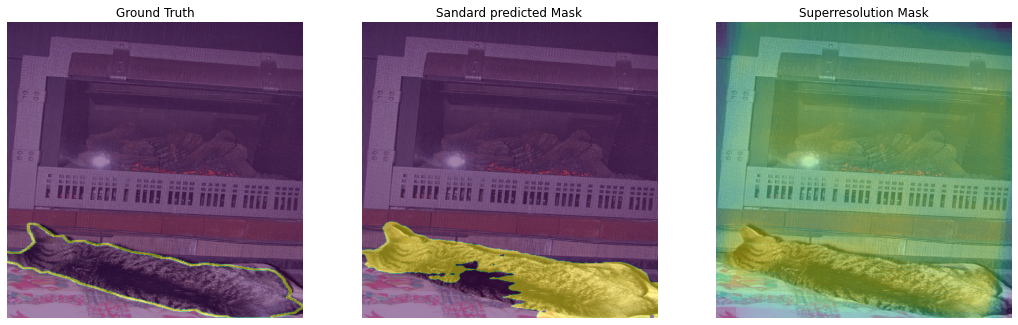

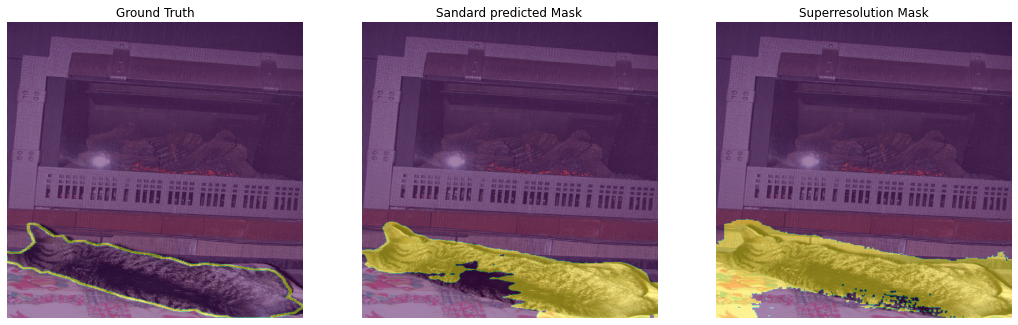

(0.8175911370997948, 0.7436499645432635)

In [19]:
plot_standard_superres(sample_image, true_mask, sample_standard, sample_superres)
plot_standard_superres(sample_image, true_mask, sample_standard, sample_superres_th)
evaluate_IOU(true_mask, sample_standard, sample_superres_th)

In [20]:
th_ranges = np.arange(0.50, 1.0, 0.05)
results = {}

for th_value in th_ranges:
    superres_masks_dict_th_test = {}
    for key in superres_masks_dict:
        target_dict = superres_masks_dict[key]
        target_mask = target_dict["class"]

        th_mask_value = tf.cast(tf.reduce_max(target_mask), tf.float32) * th_value
        th_mask = tf.where(target_mask > th_mask_value, CLASS_ID, 0)
        superres_masks_dict_th_test[key] = th_mask.numpy()

    standard_IOUs, superres_IOUs = compare_results(images_dict, standard_masks_dict, superres_masks_dict_th_test, image_size=IMG_SIZE, verbose=False)

    mean_standard_IOUs = np.mean(standard_IOUs)
    mean_superres_IOUs = np.mean(superres_IOUs)
    results[th_value] = (mean_standard_IOUs, mean_superres_IOUs)
    print(f"Threshold Value: {th_value} -- Standard mean IOU: {np.mean(standard_IOUs)},  Superres mean IOU: {np.mean(superres_IOUs)}")

Threshold Value: 0.5 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.22651434549393304
Threshold Value: 0.55 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.2751345775039064
Threshold Value: 0.6000000000000001 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.34061444775566735
Threshold Value: 0.6500000000000001 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.4262386435982497
Threshold Value: 0.7000000000000002 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.5300017760518527
Threshold Value: 0.7500000000000002 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.6378448451988576
Threshold Value: 0.8000000000000003 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.7480555694925346
Threshold Value: 0.8500000000000003 -- Standard mean IOU: 0.8432970924901599,  Superres mean IOU: 0.82587504488637
Threshold Value: 0.9000000000000004 -- Standard mean IOU: 0.8432970924901599,  Superres mean 

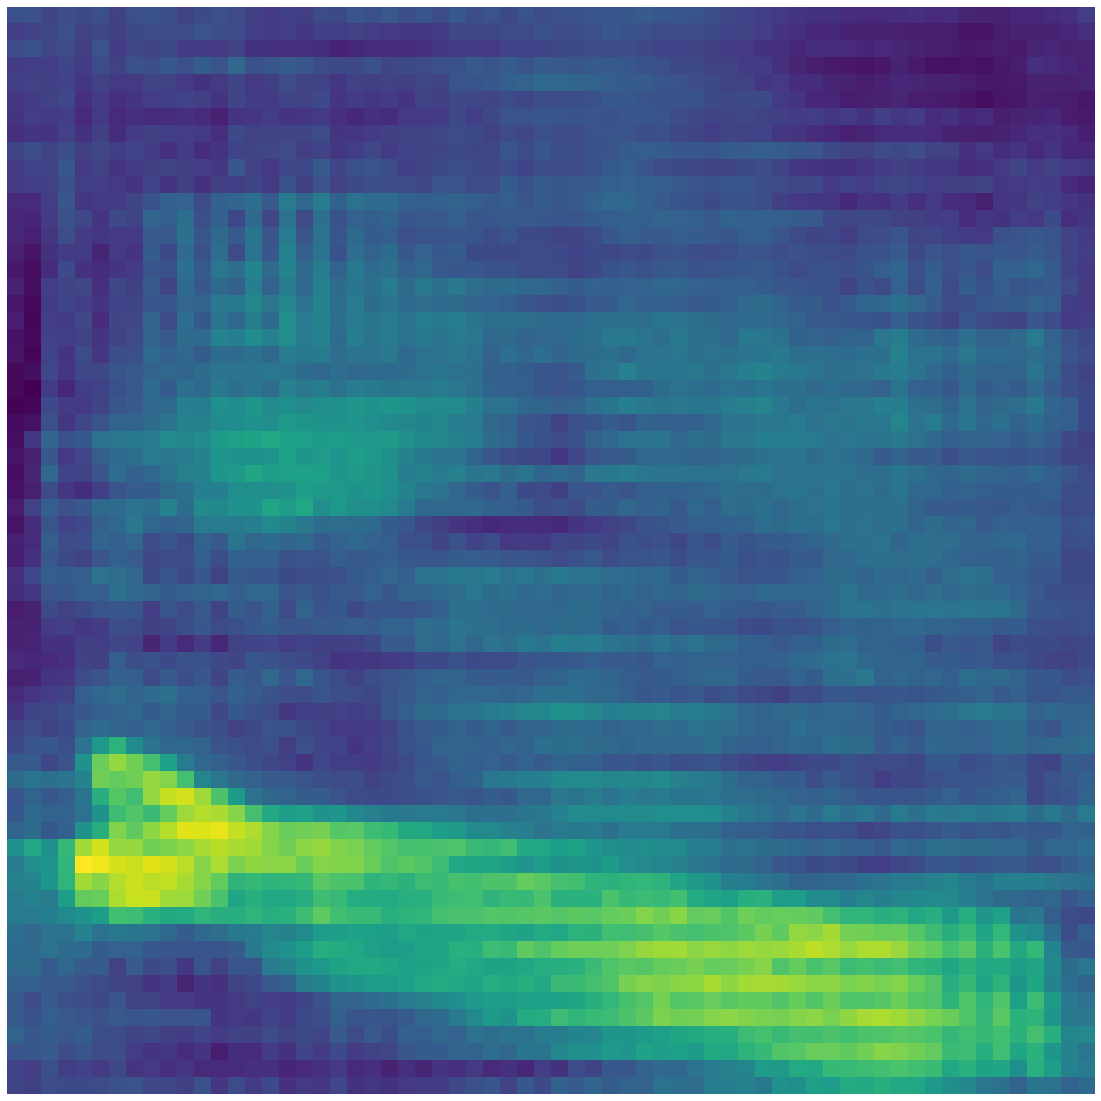

In [21]:
plot_image(augmented_features_dict[sample_key]["class"][0])

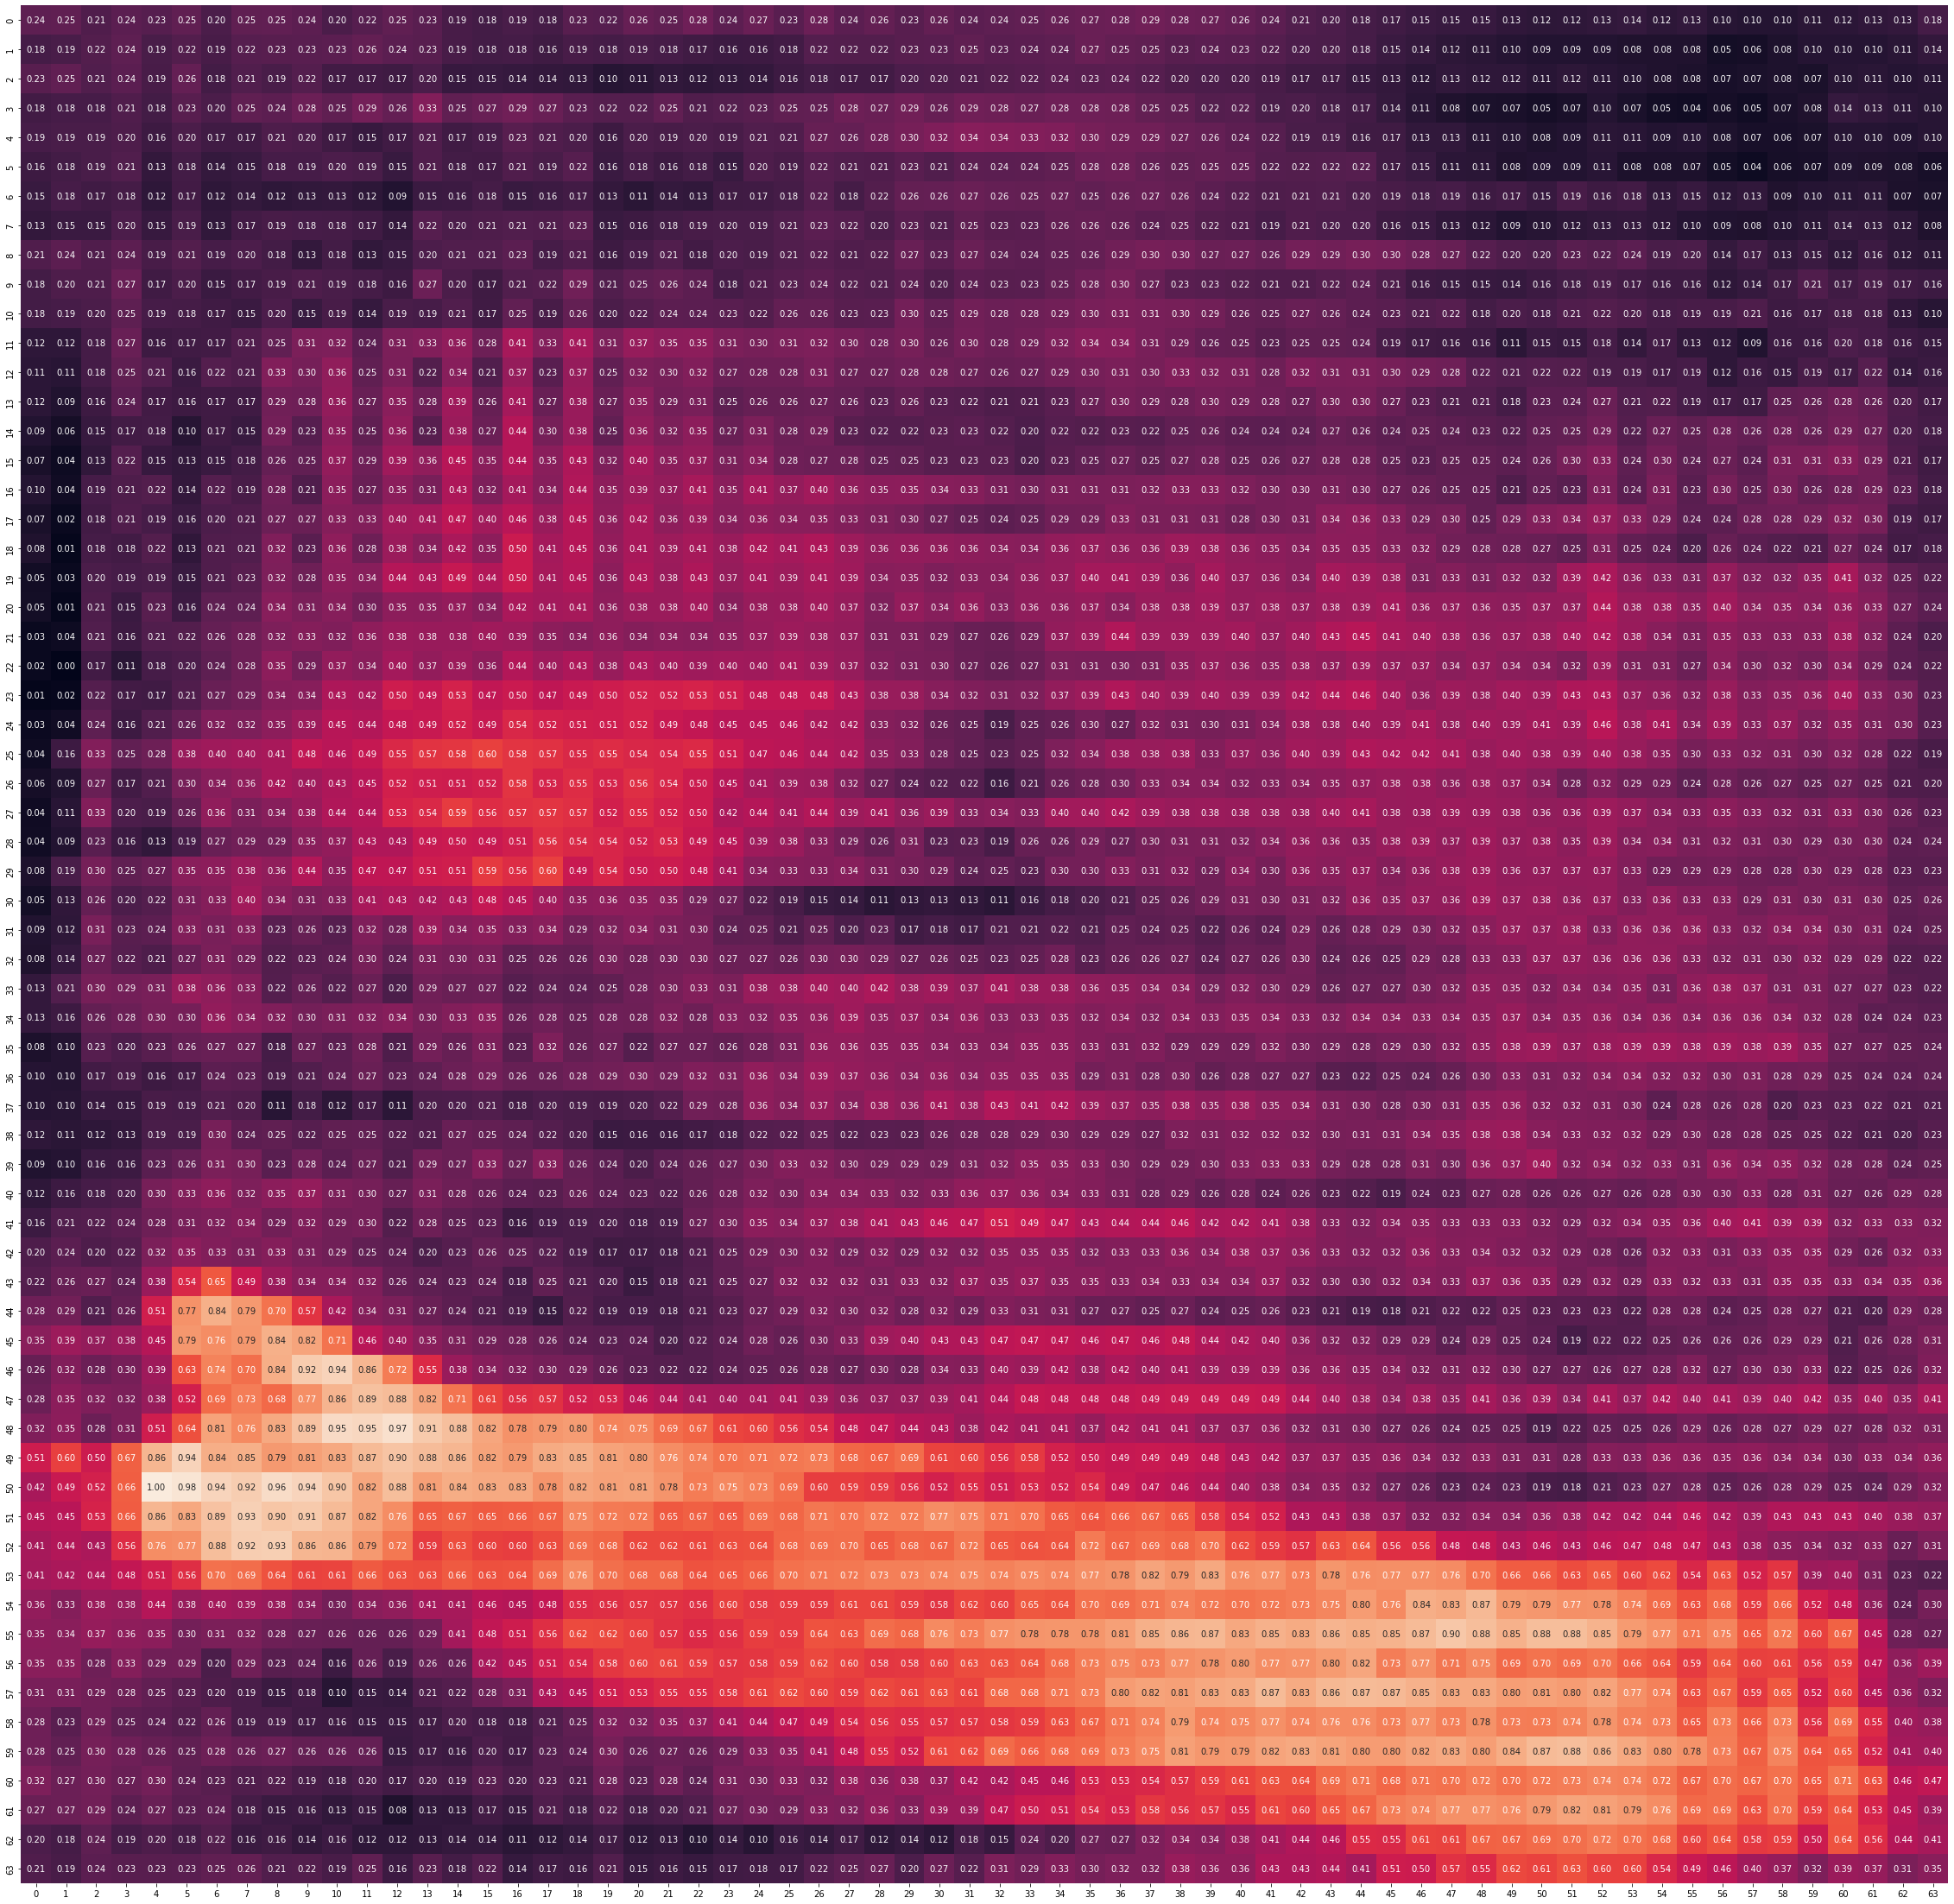

In [23]:
plt.figure(figsize=(40, 40))
ax = sns.heatmap(a[..., -1], annot=True, cbar=False, fmt=".2f")